In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,precision_recall_curve, f1_score,make_scorer, fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


In [36]:
df.dtypes

FeatureX                    int64
FeatureY                    int64
User_ID                    object
Countries_ID               object
Created At time            object
Created At Year             int64
Created At Month            int64
Created At Day_of_month     int64
job_count                   int64
blog_activity_count         int64
competitons_count           int64
subm count 10               int64
subm count 3                int64
subm count 8                int64
subm count 9                int64
subm count 6                int64
subm count 7                int64
subm count 5                int64
subm count 4                int64
comments_count              int64
discussions_count           int64
hour                        int64
minute                      int64
second                      int64
activity_days_count         int64
target                      int64
dtype: object

In [37]:
df = pd.read_csv("/home/omarfetou7/workspace/ML_MBZ/ML/project/data/data.csv")
X = df.select_dtypes(include=["number"]).drop(columns=["target",'Created At Month','Created At Day_of_month'])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=4,
    random_state=42,
    class_weight='balanced'
)


In [39]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, beta=1):
    """
    Trains the model, evaluates default and optimal threshold, and plots results.
    """
    model.fit(X_train, y_train)
    print("Model training complete.")

    y_pred_default = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred_default, target_names=['No Fraud (0)', 'Fraud (1)']))
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"The ROC AUC score is: {auc:.4f}")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find optimal threshold using F2-score
    f2_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-9)

    optimal_idx = np.argmax(f2_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold found: {optimal_threshold:.4f}")
    print(f"This threshold gives a Precision of {precision[optimal_idx]:.4f} and a Recall of {recall[optimal_idx]:.4f}")

    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    print(classification_report(y_test, y_pred_optimal, target_names=['No Fraud (0)', 'Fraud (1)']))
    f2 = fbeta_score(y_test, y_pred_optimal, beta=2)
    print(f"F2 Score: {f2:.4f}")
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted No Fraud', 'Predicted Fraud'],
                yticklabels=['Actual No Fraud', 'Actual Fraud'])
    plt.title('Confusion Matrix with Optimal Threshold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Model training complete.
              precision    recall  f1-score   support

No Fraud (0)       0.91      0.69      0.78      2120
   Fraud (1)       0.24      0.58      0.34       363

    accuracy                           0.67      2483
   macro avg       0.57      0.63      0.56      2483
weighted avg       0.81      0.67      0.72      2483

The ROC AUC score is: 0.7089


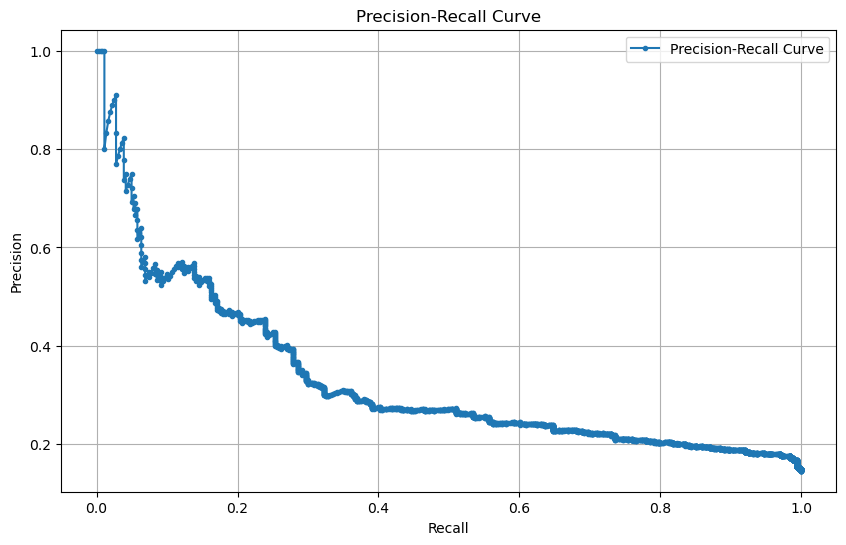

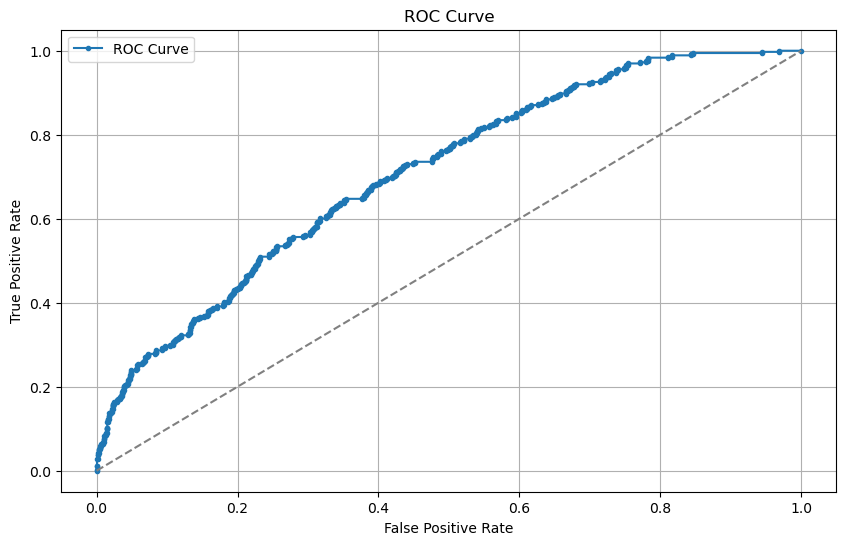


Optimal threshold found: 0.5251
This threshold gives a Precision of 0.2729 and a Recall of 0.5096
              precision    recall  f1-score   support

No Fraud (0)       0.90      0.77      0.83      2120
   Fraud (1)       0.27      0.51      0.36       363

    accuracy                           0.73      2483
   macro avg       0.59      0.64      0.59      2483
weighted avg       0.81      0.73      0.76      2483

F2 Score: 0.4343


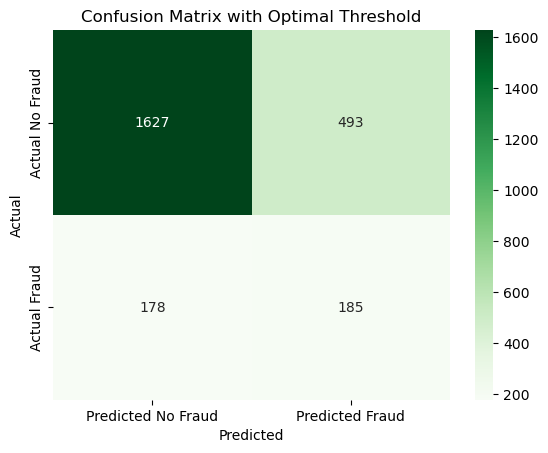

In [40]:
X_train_scaled
train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, clf)

In [41]:
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n most significant features based on feature importance from a fitted model.
    Args:
        model: Trained tree-based model with feature_importances_ attribute.
        feature_names: List of feature names.
        top_n: Number of top features to display.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    top_features = feat_imp.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    top_features.plot(kind='barh')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(top_features)

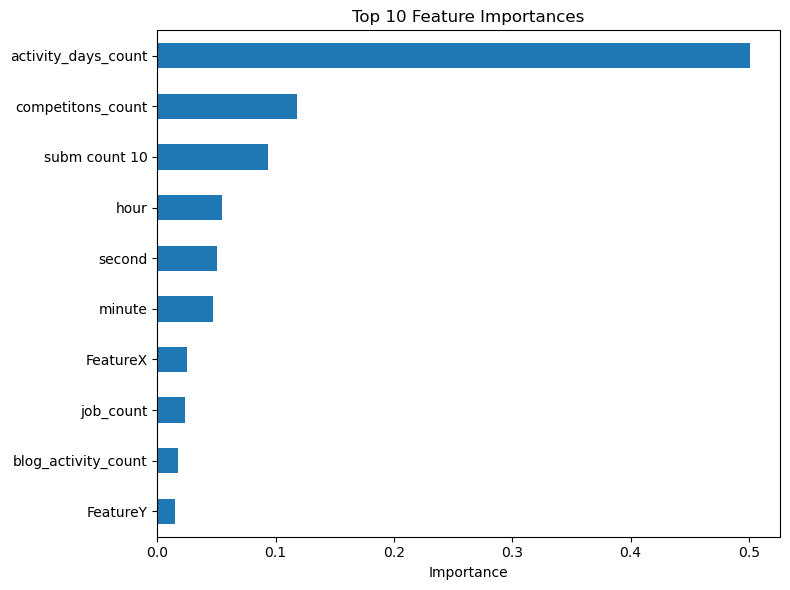

activity_days_count    0.501146
competitons_count      0.118002
subm count 10          0.093731
hour                   0.054950
second                 0.050777
minute                 0.047355
FeatureX               0.024905
job_count              0.023846
blog_activity_count    0.017879
FeatureY               0.014900
dtype: float64


In [42]:
plot_feature_importance(clf, X.columns, top_n=10)

In [43]:
X.columns.shape

(20,)

In [44]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
xgb = XGBClassifier(
    n_estimators=500,        # trees, tune with early stopping
    learning_rate=0.05,      # conservative, allows more trees
    max_depth=6,             # controls complexity
    min_child_weight=1,      # larger -> more conservative splits
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    reg_lambda=1,            # L2 regularization
    reg_alpha=0,             # L1 regularization
    scale_pos_weight=scale_pos_weight,      # adjust if imbalance exists (see below)
    objective="binary:logistic",
    eval_metric="logloss",   # use logloss during training
    random_state=42,
    n_jobs=-1,
    
)


Model training complete.
              precision    recall  f1-score   support

No Fraud (0)       0.88      0.80      0.84      2120
   Fraud (1)       0.25      0.39      0.30       363

    accuracy                           0.74      2483
   macro avg       0.57      0.59      0.57      2483
weighted avg       0.79      0.74      0.76      2483

The ROC AUC score is: 0.6853


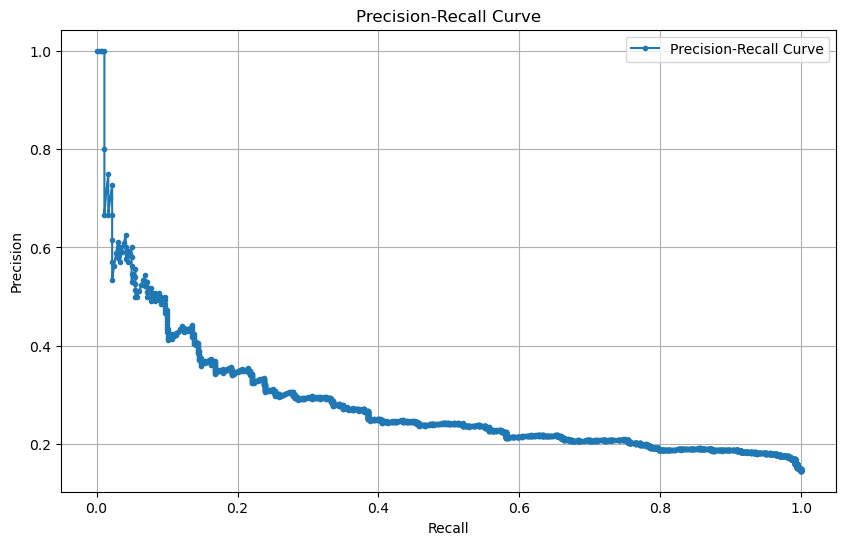

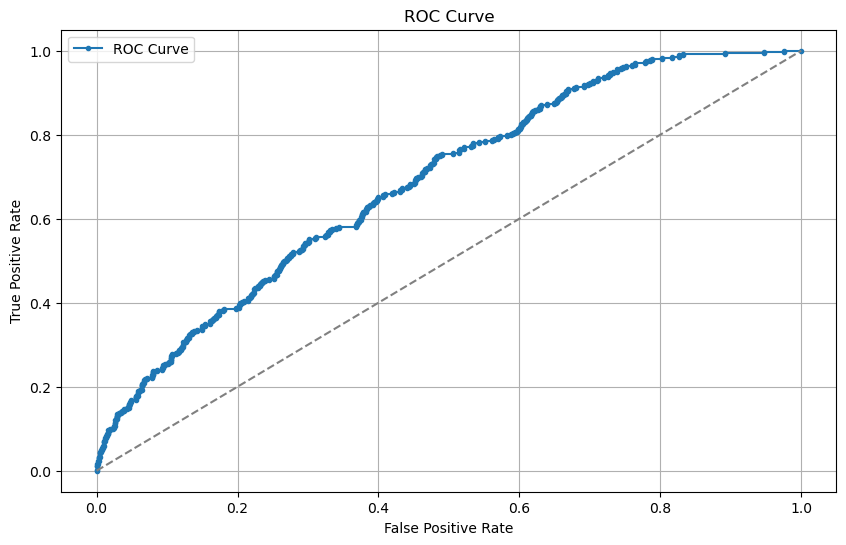


Optimal threshold found: 0.4191
This threshold gives a Precision of 0.2381 and a Recall of 0.5510
              precision    recall  f1-score   support

No Fraud (0)       0.90      0.70      0.79      2120
   Fraud (1)       0.24      0.55      0.33       363

    accuracy                           0.68      2483
   macro avg       0.57      0.62      0.56      2483
weighted avg       0.80      0.68      0.72      2483

F2 Score: 0.4363


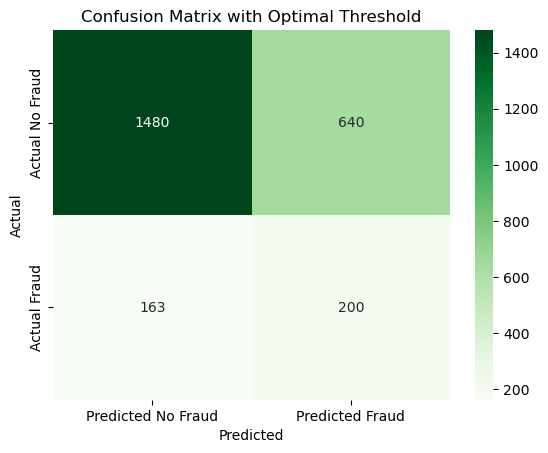

In [45]:

train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, xgb)

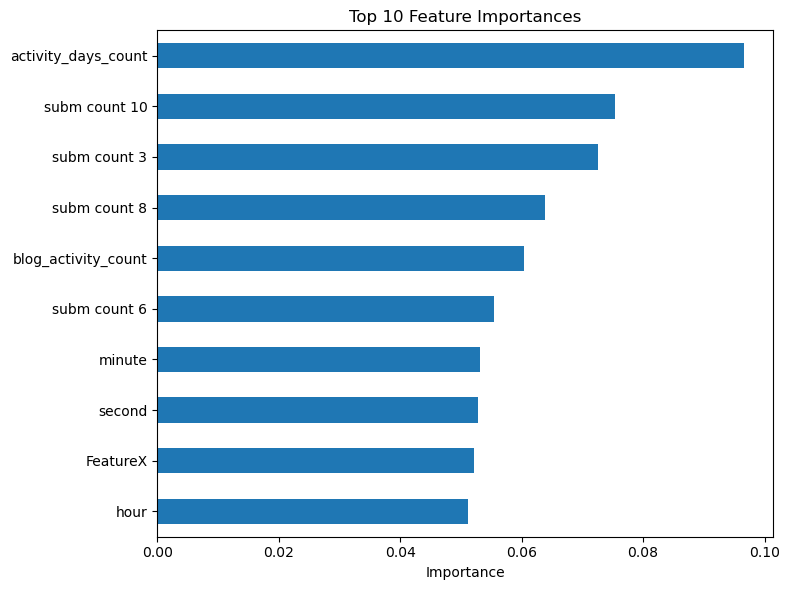

activity_days_count    0.096567
subm count 10          0.075413
subm count 3           0.072620
subm count 8           0.063916
blog_activity_count    0.060468
subm count 6           0.055437
minute                 0.053105
second                 0.052895
FeatureX               0.052129
hour                   0.051141
dtype: float32


In [46]:
plot_feature_importance(xgb, X.columns, top_n=10)